### Part 1: Library Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

### Part 2: Simple Linear Regression

In [2]:
Boston = load_data('Boston')
Boston.head(4)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4


In [3]:
# Fit a model using only 1 predictor
X = pd.DataFrame({
    'intercept': np.ones(Boston.shape[0]),
    'lstat': Boston['lstat']
})
y = Boston['medv']
model = sm.OLS(y, X)
results = model.fit()
print(summarize(results))

              coef  std err       t  P>|t|
intercept  34.5538    0.563  61.415    0.0
lstat      -0.9500    0.039 -24.528    0.0


In [4]:
# Make prediction and observe [prediction interval] is wider than [confidence interval]
new_df = pd.DataFrame({
    'intercept': np.ones(3),
    'lstat': [5, 10, 15]
})
new_pred = results.get_prediction(new_df)
print(f'Predicted values: \n{new_pred.predicted_mean}')
print()
print(f'Confidence interval: \n{new_pred.conf_int(alpha=0.05)}')
print(f'Prediction interval: \n{new_pred.conf_int(obs=True, alpha=0.05)}')

Predicted values: 
[29.80359411 25.05334734 20.30310057]

Confidence interval: 
[[29.00741194 30.59977628]
 [24.47413202 25.63256267]
 [19.73158815 20.87461299]]
Prediction interval: 
[[17.56567478 42.04151344]
 [12.82762635 37.27906833]
 [ 8.0777421  32.52845905]]


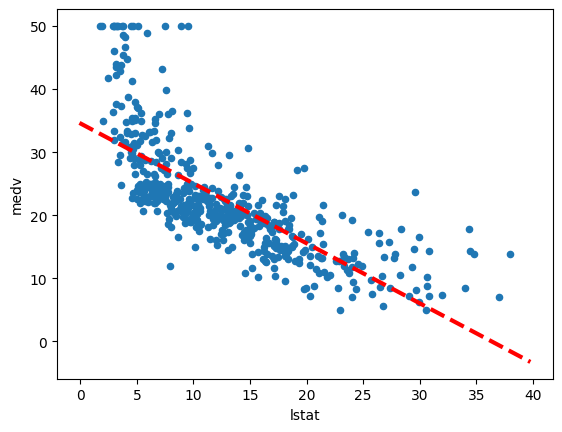

In [5]:
# Regression line plot
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=3)
    

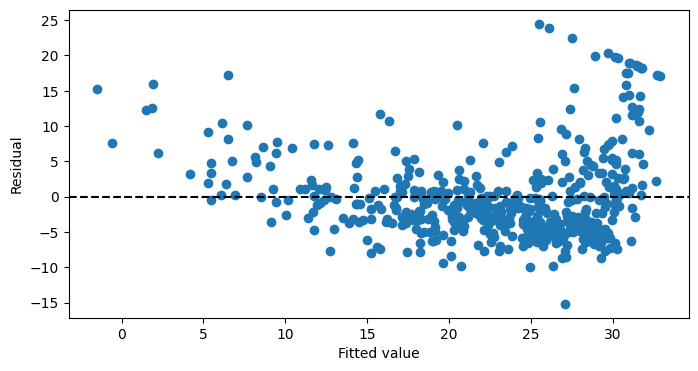

In [6]:
# Residual plot
ax = subplots(figsize=(8, 4))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

374

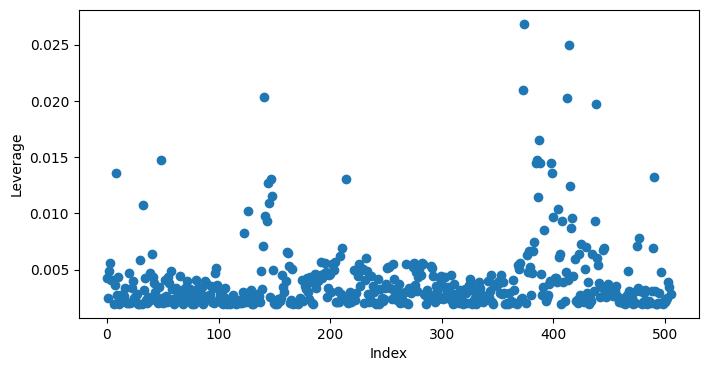

In [7]:
# Leverage plot
infl = results.get_influence()
ax = subplots(figsize=(8, 4))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

### Part 3: Multiple linear regression

In [8]:
# Linear regression with 2 predictors
X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [11]:
# Linear regression with all but high p_value predictors
terms = Boston.columns.drop(['medv', 'age', 'indus'])
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,41.4517,4.903,8.454,0.000
crim,-0.1217,0.033,-3.696,0.000
zn,0.0462,0.014,3.378,0.001
chas,2.8719,0.863,3.329,0.001
nox,-18.2624,3.565,-5.122,0.000
rm,3.6730,0.409,8.978,0.000
dis,-1.5160,0.188,-8.078,0.000
rad,0.2839,0.064,4.440,0.000
tax,-0.0123,0.003,-3.608,0.000
ptratio,-0.9310,0.130,-7.138,0.000


### Part 4: Goodness of Fit

In [17]:
# VIF (Variance inflation factors), if too high indicate collinearity
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vals}, index=X.columns[1:])
vif.head(4)

,vif
crim,1.765478
zn,2.239107
chas,1.056997
nox,3.758338


### Part 5: Interaction terms

In [18]:
# Linear regression with interaction terms
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


### Part 6: Polynomial predictors

In [22]:
# Linear regression with polynomial predictors
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


In [23]:
# Compare model fit, proving that polynomial improves the model
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


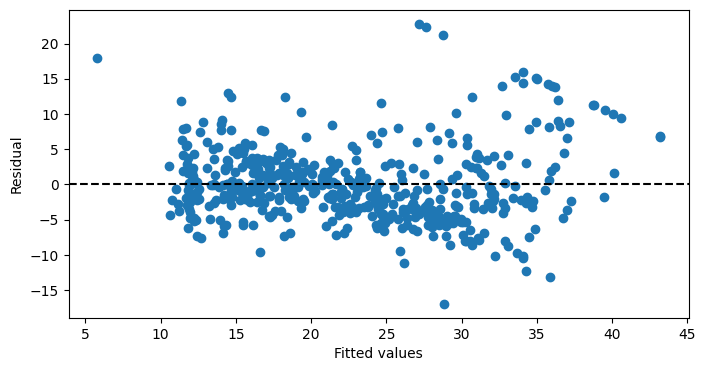

In [26]:
# Plot the new residual plot, random pattern proving valid model
ax = subplots(figsize=(8, 4))[1]
ax.scatter(results3.fittedvalues, results3.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

### Part 7: Categorical predictor

In [27]:
# Load new data
Carseats = load_data('Carseats')
Carseats.head(4)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes


In [29]:
# Using baseline as ShelveLoc = Bad, Urban = No and US = No
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'), ('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288
